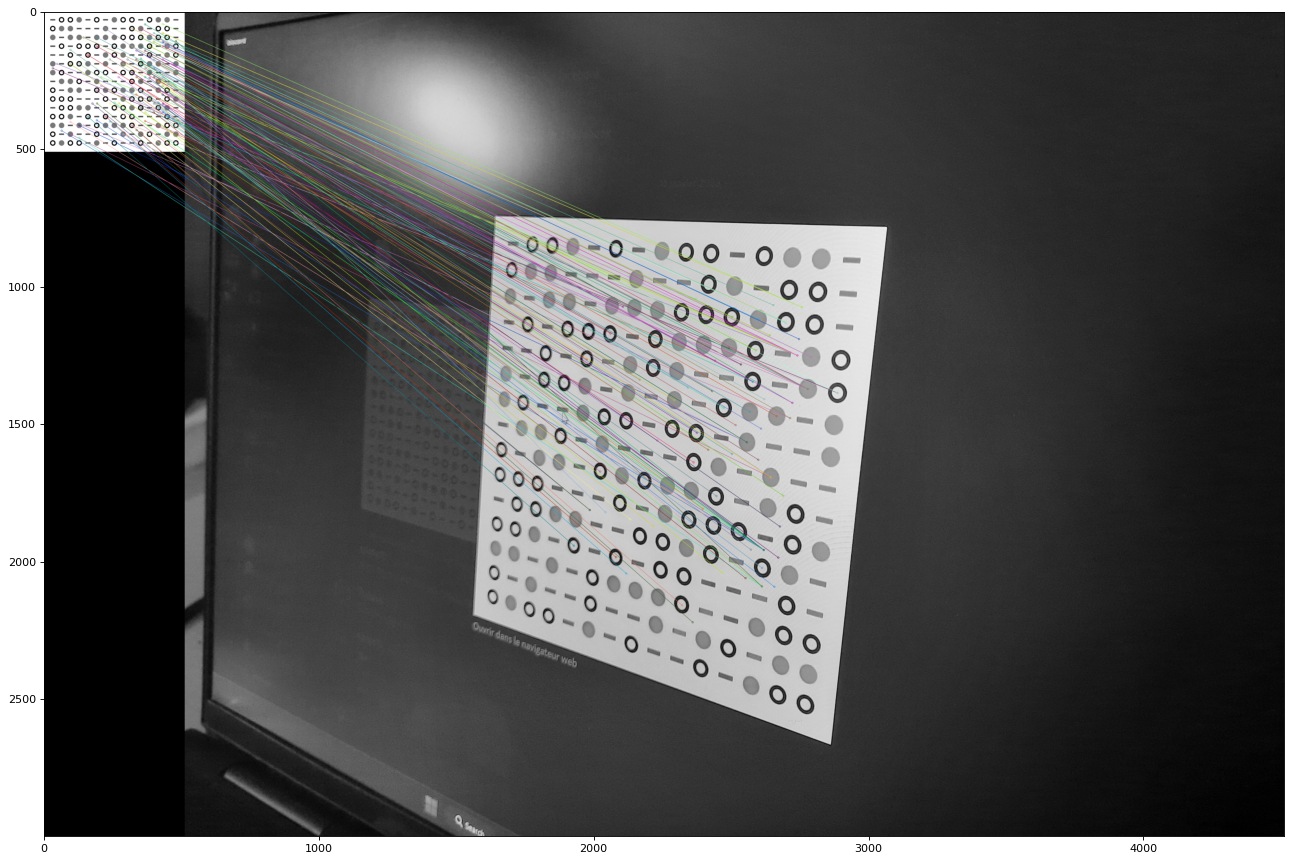

(<matplotlib.image.AxesImage at 0x1bf235b77c0>, None)

In [5]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
img1 = cv.imread('mire_315a.png',cv.IMREAD_GRAYSCALE)          # queryImage
img2 = cv.imread('mire_test.jpg',cv.IMREAD_GRAYSCALE) # trainImage
# Initiate SIFT detector
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
# BFMatcher with default params
bf = cv.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)
# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(20, 20))
plt.imshow(img3),plt.show()

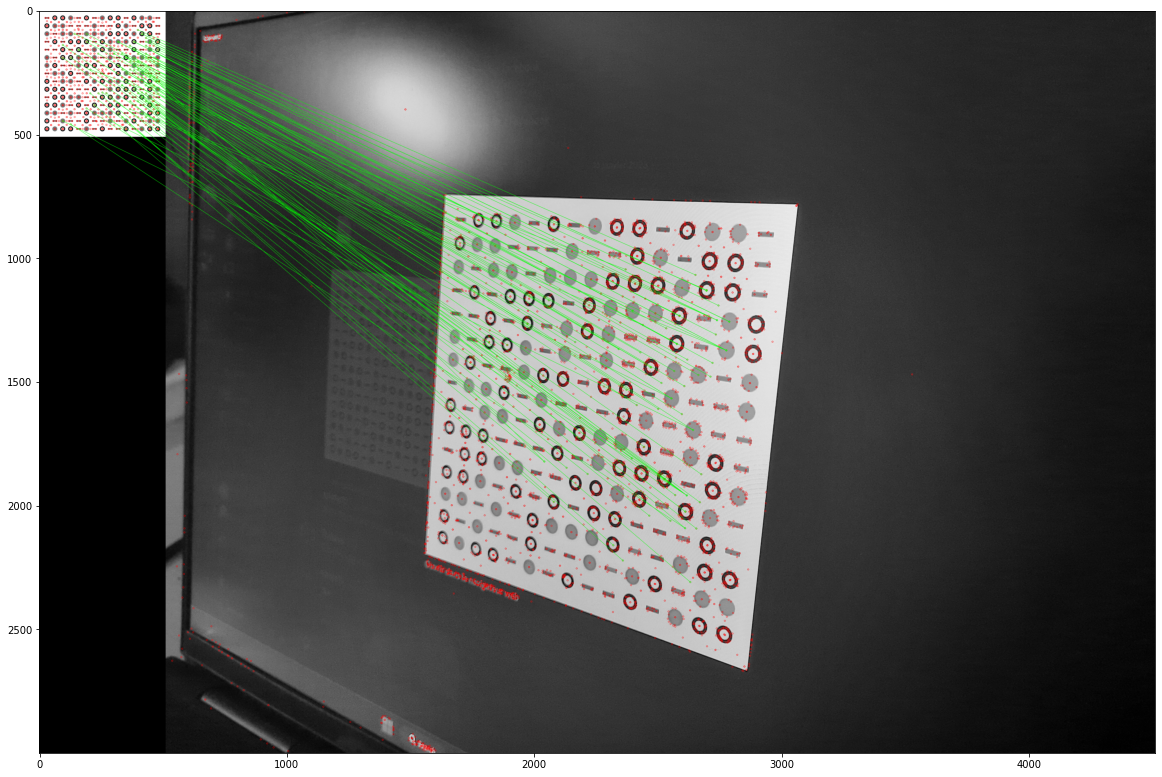

(<matplotlib.image.AxesImage at 0x1bf237735b0>, None)

In [7]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
img1 = cv.imread('mire_315a.png',cv.IMREAD_GRAYSCALE)          # queryImage
img2 = cv.imread('mire_test.jpg',cv.IMREAD_GRAYSCALE) # trainImag
# Initiate SIFT detector
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)
# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = cv.DrawMatchesFlags_DEFAULT)
img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)
plt.figure(figsize=(20, 20))
plt.imshow(img3,),plt.show()

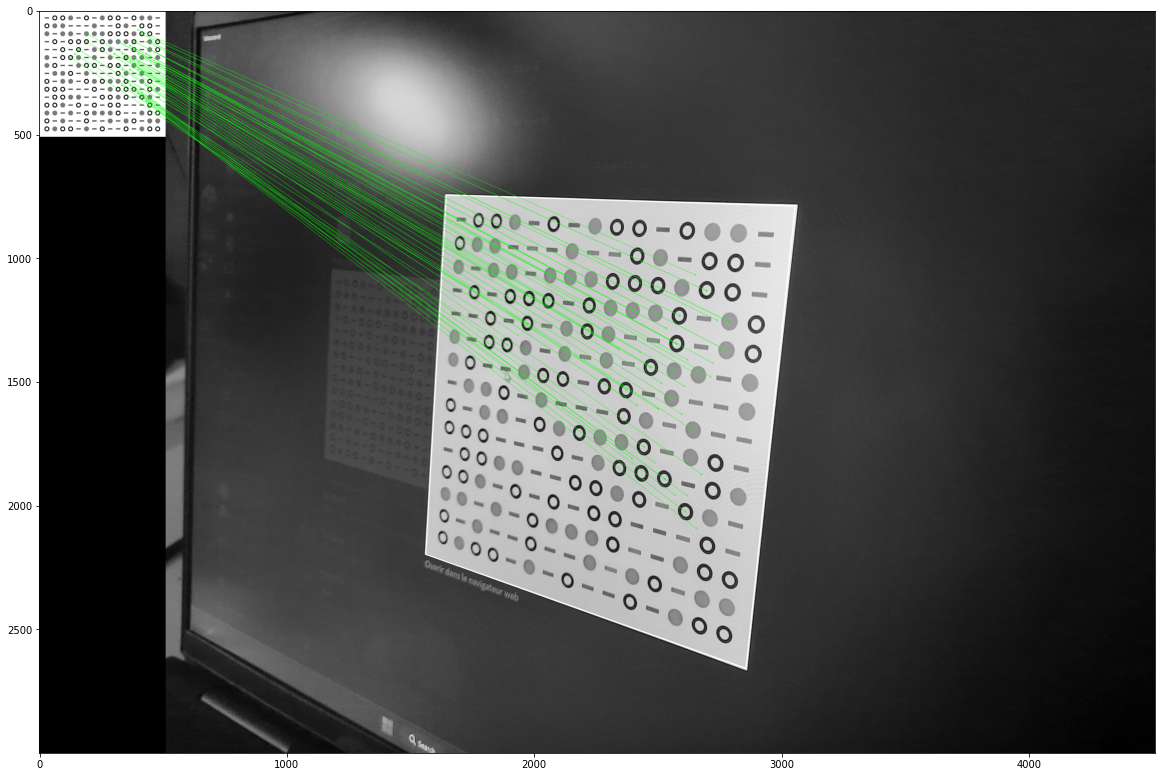

(<matplotlib.image.AxesImage at 0x1bf23566880>, None)

In [8]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
MIN_MATCH_COUNT = 10
img1 = cv.imread('mire_315a.png',cv.IMREAD_GRAYSCALE)          # queryImage
img2 = cv.imread('mire_test.jpg',cv.IMREAD_GRAYSCALE) # trainImag
# Initiate SIFT detector
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)
# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv.perspectiveTransform(pts,M)
    img2 = cv.polylines(img2,[np.int32(dst)],True,255,3, cv.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
plt.figure(figsize=(20, 20))
plt.imshow(img3, 'gray'),plt.show()

In [14]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
img_rgb = cv.imread('mire_test.jpg')
img_gray = cv.cvtColor(img_rgb, cv.COLOR_BGR2GRAY)
template = cv.imread('mire_315a_symbols_point.png',0)
w, h = template.shape[::-1]
res = cv.matchTemplate(img_gray,template,cv.TM_CCOEFF_NORMED)
threshold = 0.8
loc = np.where( res >= threshold)
for pt in zip(*loc[::-1]):
    cv.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)
cv.imwrite('res.png',img_rgb)

True

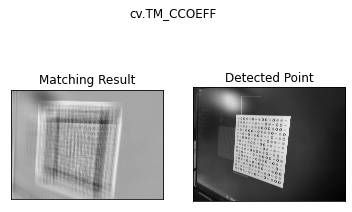

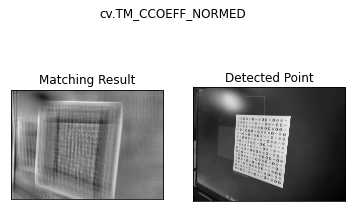

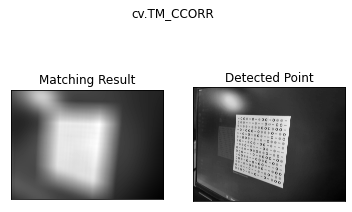

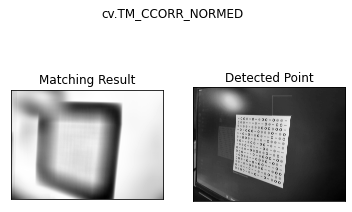

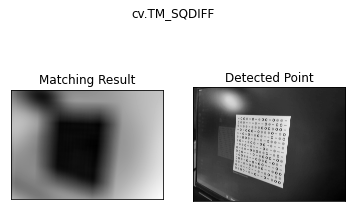

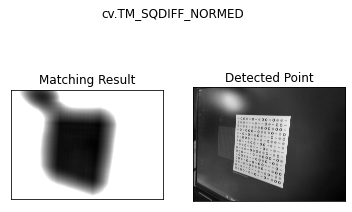

In [16]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
img = cv.imread('mire_test.jpg',0)
img2 = img.copy()
template = cv.imread('mire_315a.png',0)
w, h = template.shape[::-1]
# All the 6 methods for comparison in a list
methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR',
            'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']
for meth in methods:
    img = img2.copy()
    method = eval(meth)
    # Apply template Matching
    res = cv.matchTemplate(img,template,method)
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv.rectangle(img,top_left, bottom_right, 255, 2)
    plt.subplot(121),plt.imshow(res,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(img,cmap = 'gray')
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    plt.suptitle(meth)
    plt.show()

In [54]:
import numpy as np
import cv2
cap = cv.VideoCapture(0)


def variance_of_image_blur_laplacian(image):
	# compute the Laplacian of the image and then return the focus
	return round(cv2.Laplacian(image, cv2.CV_64F).var(), 2)

def variance_of_image_blur_sobel(image):
	# compute the Sobel of the image and then return the focus
	return round(cv2.Sobel(image,cv2.CV_64F,1,0,ksize=3 ).var(), 1)

def variance_of_image_blur_Canny(image):
	# compute the Canny of the image and then return the focus
	return round(cv2.Canny(image, 100, 200).var(), 1)

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
    # if frame is read correctly ret is True

    # Operations on the frame
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    fm_sobel = variance_of_image_blur_sobel(gray)
    fm_laplacian = variance_of_image_blur_laplacian(gray)
    fm_canny = variance_of_image_blur_Canny(gray)

    # Display the resulting frame
    cv2.putText(frame, "{}{:.2f}".format(" Sobel focus value : ", fm_sobel), (0, 30), cv.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 1, cv.LINE_AA)
    cv2.putText(frame, "{}{:.2f}".format(" Laplacian focus value : ", fm_laplacian), (0, 70), cv.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 1, cv.LINE_AA)
    cv2.putText(frame, "{}{:.2f}".format(" Canny focus value : ", fm_laplacian), (0, 110), cv.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 1, cv.LINE_AA)
    cv2.imshow('Focus value', frame)
    if cv2.waitKey(1) == ord('q'):
        break
# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()


KeyboardInterrupt: 

: 